In [1]:
# Get paths for files we already processed
# DOES NOT PREPROCESS

from pathlib import Path
import re

def get_sub(sub):
    return re.search('MRI/([0-9]+)', sub)[1]

wrfiles = dict()

pncdir = '/run/media/anton/Seagate Portable Drive/PNC/MRI/'
for p in Path(pncdir).iterdir():
    if p.is_dir():
        pp = p / 'FMRI_BOLD_emotion_identification/Dicoms'
        if pp.is_dir():
            found = False
            for f in pp.iterdir():
                if re.match('.*\d\.nii', f.name):
                    found = True
                    break
            if not found:
                print(f'Not found {pp}')
                break
            sub = get_sub(str(f))
            rfile = str(f.parent) + '/r' + f.name
            wrfile = str(f.parent) + '/wr' + f.name
            
            if Path(wrfile).exists():
                print(sub)
                wrfiles[sub] = wrfile
            else:
                print(f'Missing files for {sub}')
                break
            
print(len(wrfiles))

600001103037
600009963128
600018902293
600020364885
600020927179
600031697545
600038720566
600039015048
600039665619
600045155842
600045443700
600049785291
600051187879
600052596653
600053476714
600054124128
600059829137
600061763148
600062084650
600062741849
600085654611
600096301727
600096907755
600098941368
600109657100
600110501017
600110937794
600114922498
600116672720
600129552715
600135180939
600138617917
600153665436
600167349259
600173623767
600175632390
600176839719
600185621034
600186389348
600188665786
600201270162
600209790043
600209995267
600210241146
600210683444
600239486853
600259084705
600262185931
600263649795
600264192142
600265754263
600282088524
600294591042
600294620965
600307190856
600325379088
600330589363
600333703574
600342427856
600367706279
600377610905
600384500580
600404481268
600405811873
600409285352
600414524351
600415312234
600431843434
600441599396
600444687107
600453080018
600460215379
600467348643
600484292483
600501204197
600506506478
600515650925

604399157561
604413981131
604420388312
604434132632
604436100276
604436269093
604441463835
604446603420
604449037424
604450308385
604465259468
604465934786
604473175469
604483095823
604483341079
604488200536
604489799673
604495707329
604500607341
604509988571
604517932969
604521068011
604527984573
604530605174
604533322765
604537205278
604545149983
604549933059
604549984315
604572887538
604572945839
604582826352
604592029504
604603983999
604608523538
604619459663
604627970209
604630931488
604636396900
604645558238
604653724494
604682058707
604701576457
604701862311
604709588404
604710877570
604713776906
604716869016
604717714550
604718130562
604726744592
604740287921
604742926945
604749202816
604750579456
604754412893
604770953198
604787775991
604788495754
604794406767
604798004623
604827777386
604836600596
604843761465
604847970437
604849953034
604850834887
604851308167
604853384855
604868211055
604870683276
604876268454
604884227656
604884858379
604885183762
604899150101
604900972967

608489759196
608493398891
608510667472
608518450149
608528694385
608528837101
608532112811
608532797572
608532891053
608534981306
608539736327
608543553703
608550700819
608555786203
608573731130
608576955658
608582191991
608596377182
608598091268
608598381123
608599031686
608607242164
608618468951
608620097919
608620585035
608623975178
608643362535
608646030757
608654680296
608662450678
608665303010
608665547673
608665596582
608667434020
608670124928
608671169548
608704510310
608705674075
608711057185
608720575588
608724675350
608727242603
608732679913
608733730735
608734937907
608735330497
608738308458
608743649226
608767128938
608779146920
608780440161
608781020171
608783467254
608788361607
608793830368
608802797552
608803594523
608817343345
608817813820
608819251392
608827252332
608828085674
608837392535
608852253893
608864338417
608871204367
608886281846
608903682515
608904677685
608915092036
608927439474
608952674520
608958276291
608964917962
608965943422
608970234508
608976196675

In [11]:
import numpy as np
from nilearn import image

# Load power template coords
powerfile = '/home/anton/Documents/Tulane/Hackathon/power264/power264MNI.nii.gz'

powerimg = image.load_img(powerfile)
datpower = image.get_data(powerimg)

print(datpower.shape)

(91, 109, 91)


In [12]:
# Sort power coordinates

pcoords = []
proinums = []

for roi in range(264):
    x,y,z = np.where(datpower == roi+1)
    pcoords.append(np.stack([x,y,z,np.ones(x.shape[0])]).T)
    proinums.append(roi*np.ones(x.shape[0]))
    
pcoords = np.concatenate(pcoords).T
proinums = np.concatenate(proinums)

print(pcoords.shape)
print(proinums.shape)

(4, 21384)
(21384,)


In [14]:
from scipy.interpolate import interpn

tsdict = dict()

for i,sub in enumerate(wrfiles.keys()):
    if sub in tsdict:
        print(f'Skipping {sub}')
        continue
        
    if i % 20 == 0:
        print(f'Running {i} {sub}')

    # Load the nii image
    imgname = wrfiles[sub]
    img = image.load_img(imgname)
    img = image.smooth_img(img, 5)
    datimg = image.get_data(img)

    # Transform coords from power image space to nii image space
    coords = np.linalg.inv(img.affine)@powerimg.affine@pcoords
    points = [np.arange(s) for s in img.shape[:-1]]

    # Set up data structures
    nt = datimg.shape[-1]
    ts = np.zeros((264,nt))
    res = np.zeros((nt,coords.shape[-1]))

    # Interpolate fractional coords
    for tp in range(nt):
        res[tp] = interpn(points, datimg[:,:,:,tp], coords[:-1].T, bounds_error=True)

    # Each roi composed of mean of a ball of coordinates
    for roi in range(264):
        ts[roi] = np.mean(res[:,proinums == roi], axis=1)

    tsdict[sub] = ts
    
print(list(tsdict.keys()))

Running 0 600001103037
Running 20 600085654611
Running 40 600201270162
Running 60 600377610905
Running 80 600540131214
Running 100 600657872170
Running 120 600778221586
Running 140 600928302123
Running 160 601034752021
Running 180 601121451354
Running 200 601253138009
Running 220 601411363678
Running 240 601576804608
Running 260 601729431337
Running 280 601860011102
Running 300 602057474591
Running 320 602212580821
Running 340 602324913001
Running 360 602456401454
Running 380 602587201685
Running 400 602736411654
Running 420 602898753625
Running 440 603056110671
Running 460 603213455413
Running 480 603362886729
Running 500 603519353680
Running 520 603660816657
Running 540 603783356574
Running 560 603889816024
Running 580 604008355365
Running 600 604177671628
Running 620 604300485875
Running 640 604449037424
Running 660 604549984315
Running 680 604717714550
Running 700 604853384855
Running 720 604987728165
Running 740 605137290405
Running 760 605300352682
Running 780 605481196229
Runnin

In [15]:
import pickle

pickle.dump(tsdict, open('../../PNC_Good/PNC_SPM_emoid_smooth.pkl', 'wb'))

print('Complete')

Complete


In [16]:
from scipy import signal

def butter_bandpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = [cutoff[0] / nyq, cutoff[1] / nyq]
    b, a = signal.butter(order, normal_cutoff, btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

ts = tsdict[sub]

tr = 3

filt_ts = butter_bandpass_filter(ts, [0.01, 0.15], 1/tr)

print('Done')

Done


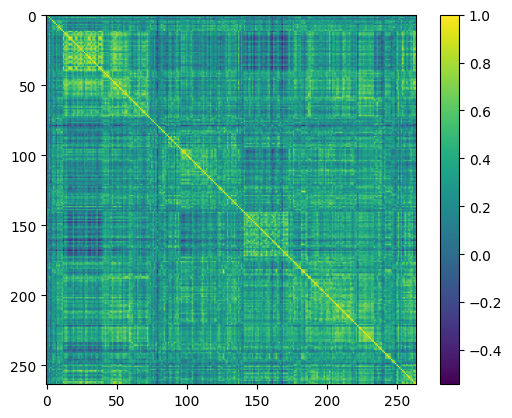

In [17]:
import matplotlib.pyplot as plt

p = np.corrcoef(filt_ts)

plt.imshow(p)
plt.colorbar()
plt.show()

In [23]:
# Check against existing ts and FC

import pickle

oldts = pickle.load(open('../../PNC_Good/PNC_SPM_emoid_good_filt.pkl', 'rb'))

# print(f'sub-{sub}' in list(oldts.keys()))
print(sub in list(oldts.keys()))

True


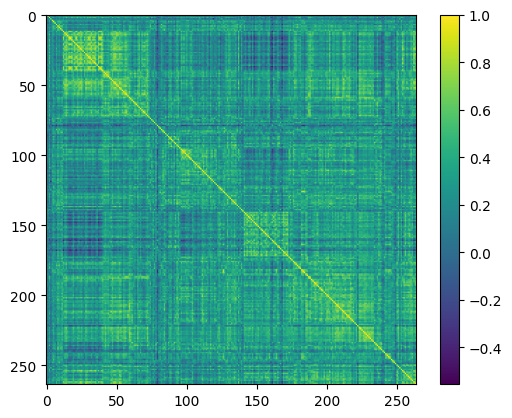

In [24]:
# ots = oldts['emoid'][f'sub-{sub}']
ots = oldts[sub]
filt_ts = butter_bandpass_filter(ots, [0.01, 0.15], 1/tr)
op = np.corrcoef(filt_ts)

plt.imshow(op)
plt.colorbar()
plt.show()

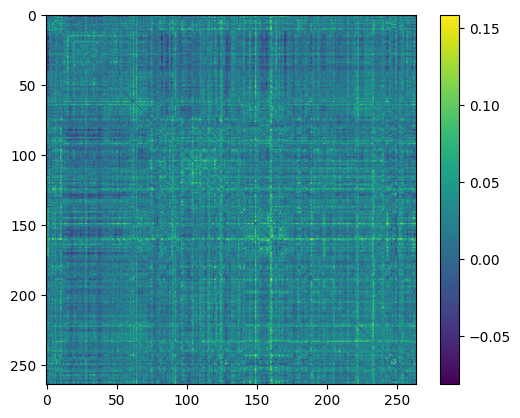

In [25]:
# Difference between SPM and fmriprep

plt.imshow(p-op)
plt.colorbar()
plt.show()


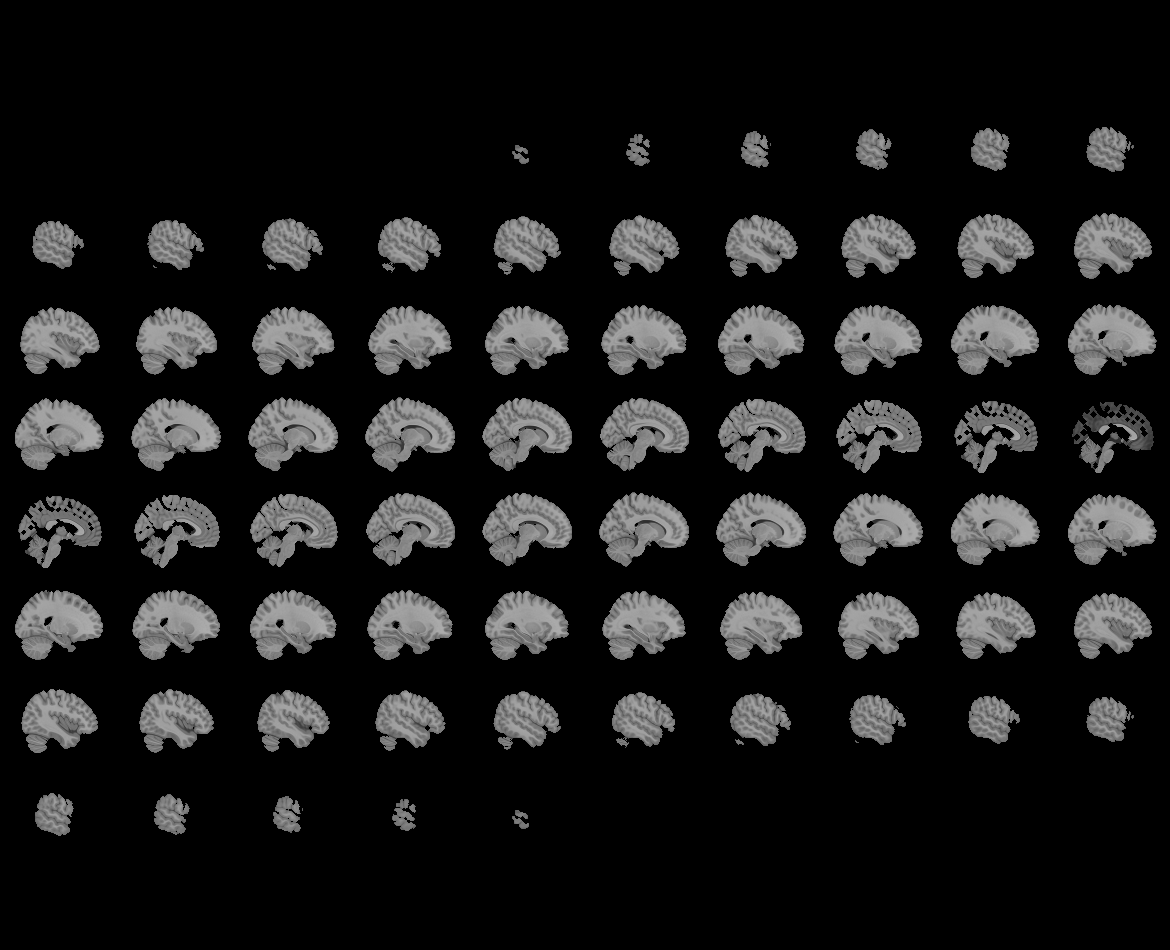
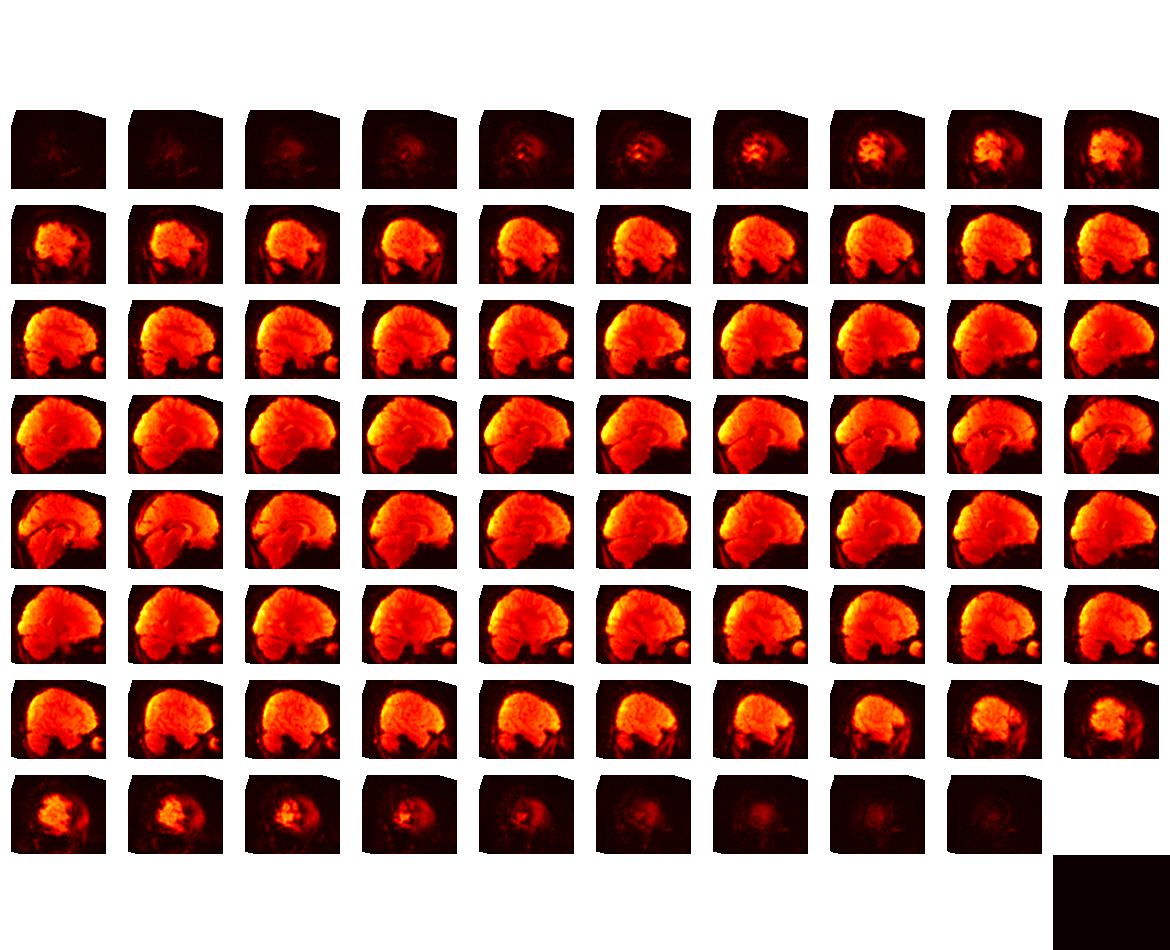

In [10]:
from nilearn import plotting

vol = image.index_img(img, 12)
plotting.view_img(vol)